# Collaboration and Competition

---


### Start the Environment

Run the next code cells to load a few packages, and start the environment. This might take a few minutes to run.

In [1]:
import numpy as np
import gym
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from collections import OrderedDict

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
'''
env = UnityEnvironment(file_name="Soccer_Windows_x86_64/Soccer.app")

brains = env.brain_names
# get the default brain
env_infos = [env.reset(train_mode=True)[brain_name] for brain_name in brains]
# number of agents
num_agents = [len(env_info.agents) for env_info in env_infos]
# size of each action
action_sizes = [env.brains[brain_name].vector_action_space_size for brain_name in brains]
# examine the state space 
state_size = [env_info.vector_observations.shape[1] for env_info in env_infos]
'''
print('')

In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="Soccer_Windows_x86_64/Soccer.app")
# reset the environment
env_info = env.reset(train_mode=True)

# print the brain names
print('Brains available:', env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)
g_action_type = g_brain.vector_action_space_type
s_action_type = s_brain.vector_action_space_type

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Brains available: ['GoalieBrain', 'StrikerBrain']
Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### Train the MADDPG agents

Run the code cells below to train the agents.

#### Hyperparameter selection

To see a description of what each one does read the report.md file.

In [29]:
## Initialise parameters ##
p = OrderedDict()

num_agents = num_s_agents
action_size = 4 #s_action_size
state_size = s_state_size
## Environment_parameters ##
p.update(num_agents=num_agents, action_size=action_size, action_type=s_action_type, state_size=state_size)

## Episode_parameters ##
p.update(number_of_episodes=3000, episode_length=300, episodes_before_training=200,
                                 learn_steps_per_env_step=3, catchup_tau=.01, catchup_threshold=1.15)
## Replay_Buffer_parameters ##
p.update(buffer_size=50000, n_steps =5)

## Agent_parameters ##
p.update(discount_rate=0.99, tau=0.0001, lr_actor=0.00025, lr_critic=0.0005)

## Model_parameters ##
p.update(batchsize=256, hidden_in_size=300, hidden_out_size=200, l2_decay=0.0001)

## Categorical_parameters ##
p.update(num_atoms=51, vmin=-2, vmax=2)

## Noise_parameters ##
p.update(noise_type='WeightedNoise', noise_reduction=0.998 , noise_scale_end=0.001,
                               OU_mu=0, OU_theta=0.2, OU_sigma=0.2)

In [30]:
# set seed and print it for reference
random_seed = np.random.randint(1000)
random_seed

475

In [31]:
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor, hard_update, soft_update
from collections import deque

# set the random seed - this allows for reproducibility
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# how many episodes to save network weights
save_interval = 300
t = 0

# amplitude of noise
# this slowly decreases to 0
noise_reduction = p['noise_reduction'] # each episode we decay the noise by this
noise_scale = np.ones(num_agents) # we start the noise at 1
noise_scale_end = p['noise_scale_end'] # the noise will never drop below this


# some performance metrics to keep track of for graphing afterwards
agent_scores = [[],[]]
agent_scores_last_100 = [deque(maxlen = 100),deque(maxlen = 100)]
agent_scores_avg, previous_agent_scores_avg = np.zeros(num_agents), np.zeros(num_agents)

log_path = os.getcwd()+"/soccer_log" # we save tensorboard logs here
model_dir= os.getcwd()+"/soccer_model_dir" # we save the model files here, to be reloaded for watching the agents

os.makedirs(model_dir, exist_ok=True) # make the directory if it doesn't exist


# keep 50000 timesteps worth of replay, with n-step-5 bootstraping, and 0.99 discount rate
buffer = ReplayBuffer(size = p['buffer_size'], n_steps = p['n_steps'], discount_rate = p['discount_rate'])

# initialize actor and critic networks and ddpg agents, passing all parameters to it
maddpg = MADDPG(p)

logger = SummaryWriter(logdir=log_path) # used for tensorboard

# training loop
# show progressbar of several metrics of interest
import progressbar as pb
# all the metrics progressbar will keep track of
widget = ['episode: ', pb.Counter(),'/',str(p['number_of_episodes']),' ',
            pb.DynamicMessage('a0_avg_score'), ' ', pb.DynamicMessage('a1_avg_score'), ' ',
            pb.DynamicMessage('a0_noise_scale'), ' ', pb.DynamicMessage('a1_noise_scale'), ' ',
            pb.DynamicMessage('buffer_size'), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ] 

timer = pb.ProgressBar(widgets=widget, maxval=p['number_of_episodes']).start() # progressbar

# initialise the environment
env_info = env.reset(train_mode=True)                  # reset the environment    
g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)

# train the agents
for episode in range(0,p['number_of_episodes']):
    training_flag = episode >= p['episodes_before_training'] # the training flag denotes whether to begin training

    if training_flag: # if training
        for agent_num in range(num_agents): # for both agents
            if agent_scores_avg[agent_num]>previous_agent_scores_avg[agent_num]: # if the score is improving
                noise_scale[agent_num] = max(noise_scale[agent_num]*noise_reduction,noise_scale_end) # then reduce noise

    timer.update(episode, a0_avg_score=agent_scores_avg[0], a1_avg_score=agent_scores_avg[1], 
                 a0_noise_scale=noise_scale[0], a1_noise_scale=noise_scale[1], buffer_size=len(buffer)) # progressbar

    buffer.reset() # reseting the buffer is neccessary to ensure the n-step bootstraps reset after each episode
    reward_this_episode = np.zeros(num_agents) # keeping track of episode reward
    if training_flag: # useful for viewing the agent in full screen, otherwise leave as is
        env_info = env.reset(train_mode=True)
    else:
        env_info = env.reset(train_mode=True)
        
    # we get states directly from the environment
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_obs = [agent_obs for agent_obs in g_states] # and reshape them into a list
    s_obs = [agent_obs for agent_obs in s_states]

    # save model or not this episode
    save_info = ((episode) % save_interval < 1 or episode==p['number_of_episodes']-1)

    for episode_t in range(p['episode_length']):
        
        t += 1 # increment timestep counter
        # explore only for a certain number of episodes
        # action input needs to be transposed
        if training_flag:
            s_actions_probs = maddpg.act(transpose_to_tensor([s_obs]), noise_scale=noise_scale) # the actors actions
            s_actions_array = torch.stack(s_actions_probs).detach().numpy().squeeze() # converted into a np.array
            s_actions_array = np.array([np.random.choice([0,1,4,5],p=probs) for probs in s_actions_array]) # discrete
        else:
            s_actions_array = np.random.randint(s_action_size, size=num_s_agents) # behave randomly before training

        # select actions and send to environment
        g_actions_array = np.array([2,2])


        #s_actions = np.random.randint(s_action_size, size=num_s_agents)
        actions = dict(zip([g_brain_name, s_brain_name],[g_actions_array, s_actions_array]))
        env_info = env.step(actions)       # input the actions into the env

        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        g_next_obs = [agent_obs for agent_obs in g_next_states] # and reshape them into a list 
        s_next_obs = [agent_obs for agent_obs in s_next_states]
        
        # get reward and update scores
        g_rewards = np.array(env_info[g_brain_name].rewards)
        s_rewards = np.array(env_info[s_brain_name].rewards)
        
        # check if episode finished
        dones = np.any(env_info[g_brain_name].local_done)   # and whether the env is done

        # add data to buffer
        transition = ([s_obs, s_actions_array, s_rewards, s_next_obs, dones])
        buffer.push(transition)
        
        # roll over states to next time step
        g_obs = g_next_obs
        s_obs = s_next_obs
        
        # for calculating rewards for this particular episode - addition of all time steps
        #reward_this_episode += rewards
        g_scores += g_rewards
        reward_this_episode += s_rewards
        
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    # update the episode scores being kept track of - episode score, last 100 scores, and rolling average scores

    for agent_num in range(num_agents):
        previous_agent_scores_avg[agent_num] = agent_scores_avg[agent_num]
        agent_scores[agent_num].append(reward_this_episode[agent_num])
        agent_scores_last_100[agent_num].append(reward_this_episode[agent_num])
        agent_scores_avg[agent_num] = np.mean(agent_scores_last_100[agent_num])

    # update agents networks
    if (len(buffer) > p['batchsize']) & training_flag:
        for _ in range(p['learn_steps_per_env_step']): # learn multiple times at every step
            for agent_num in range(p['num_agents']): # for both agents
                if agent_scores_avg[agent_num] < (p['catchup_threshold']*min(agent_scores_avg)+0.01):# if agent too far ahead then wait
                    samples = buffer.sample(p['batchsize']) # sample the buffer
                    maddpg.update(samples, agent_num, logger=logger) # update the agent
                    maddpg.update_targets(agent_num) # soft update the target network towards the actual networks
                    #if t % C == 0:
                    #    maddpg.hard_update_targets(agent_num) # hard update the target network towards the actual networks
                    # this can be used instead of soft updates
                '''
                else:
                    # update the target networks of the worse agent towards the better one
                    soft_update(maddpg.maddpg_agent[1-agent_num].actor,maddpg.maddpg_agent[agent_num].actor,p['catchup_tau'])
                    soft_update(maddpg.maddpg_agent[1-agent_num].critic,maddpg.maddpg_agent[agent_num].critic,p['catchup_tau'])
                '''
    
    # add average score to tensorboard
    if (episode % 100 == 0) or (episode == p['number_of_episodes']-1):
        for a_i, avg_rew in enumerate(agent_scores_avg):
            logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)
            
    #saving model
    save_dict_list =[]
    if save_info:
        for i in range(num_agents):
            save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                         'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                         'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                         'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
            save_dict_list.append(save_dict)
            torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format(episode)))

#env.close()
logger.close()
timer.finish()

episode: 200/3000 a0_avg_score: -0.0731 a1_avg_score: -0.183 a0_noise_scale:  0.998 a1_noise_scale:  0.998 buffer_size:  44229 ETA:   1:44:58 |/| 

ValueError: operands could not be broadcast together with shapes (6,) (1,4) 

In [7]:
np.array([2,4])

array([2, 4])

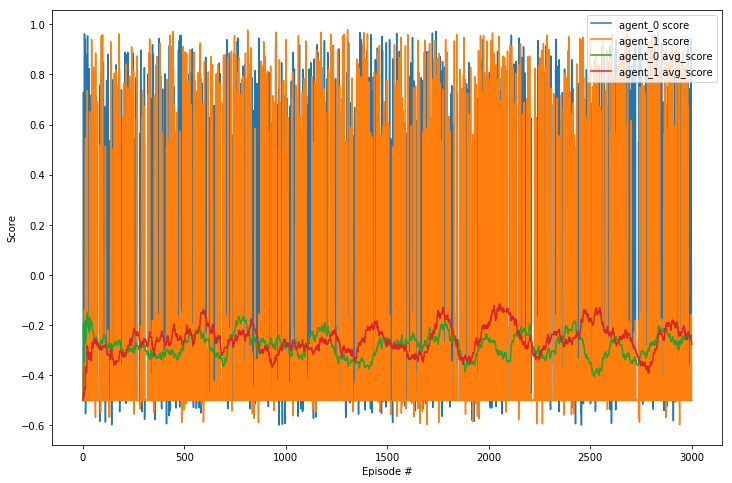

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(num_agents):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(num_agents):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

    
    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

### Note above - after enough episodes have elapsed I manually interupt the training

The results can be seen in the graph below:

In [ ]:
env.close()

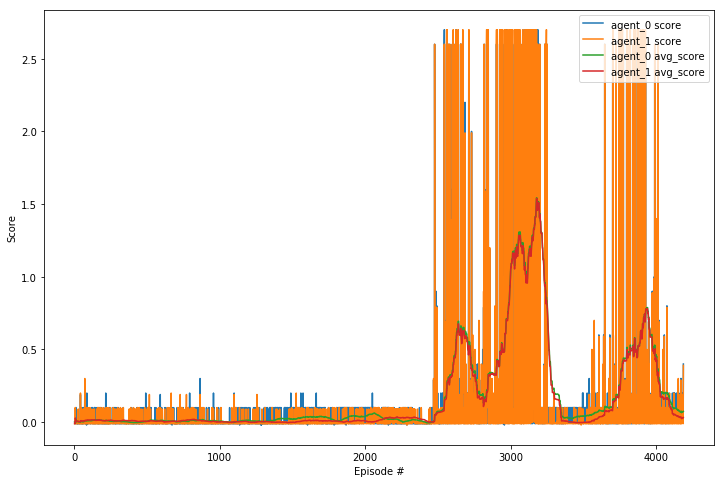

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(num_agents):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(num_agents):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

    
    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

## Appendix
### Graphs showing past performance

#### for reference below are some runs of agents before using distributional q-learning.
note that these agents were unable to acheive the required score to solve the environment, oweing to the effectiveness of distributional learning.

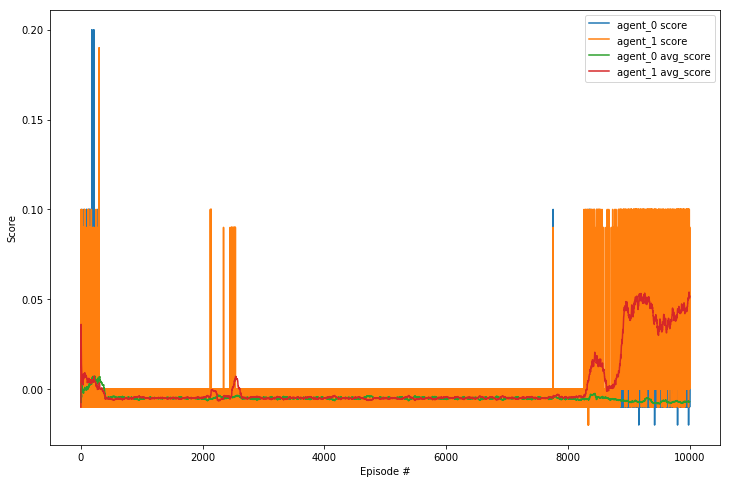

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(2):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

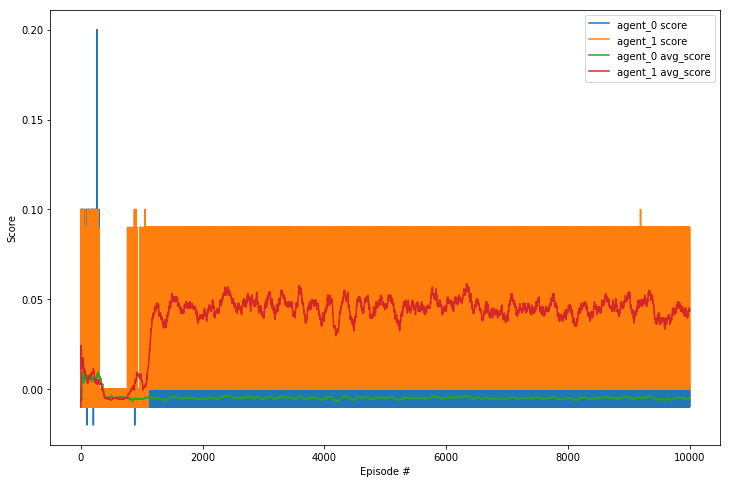

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(2):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

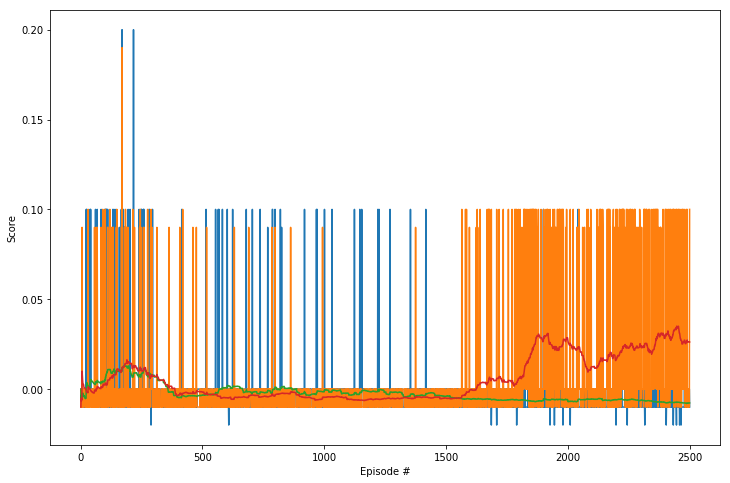

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax_0 = fig.add_subplot(111)
for agent_num in range(2):
    plt.plot(np.arange(1, len(agent_scores[agent_num])+1), agent_scores[agent_num], label=['agent_0 score','agent_1 score'][agent_num])
for agent_num in range(2):
    agent_score_avg = [np.mean(agent_scores[agent_num][max(0,i-100+1):(i+1)]) for i in range(len(agent_scores[agent_num]))]
    plt.plot(np.arange(1, len(agent_score_avg)+1), agent_score_avg, label=['agent_0 avg_score','agent_1 avg_score'][agent_num])

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper right')
plt.show()

### How to use tensorboard

To use tensorboard, simply open a terminal and type the following commands:

    1. cd **your MADDPG directory**
    2. tensorboard --logdir log